# HARK meets SSJ: 
## HANK model with `IndShockConsumerType` and Sequence Space Toolbox

This notebook solves a Heterogeneous Agent model using HARK, computes the steady state and Jacobians. These are used as inputs for the [Sequence-Space Toolbox](https://github.com/shade-econ/nber-workshop-2022) which adds general equilibrium components.

Hence, we can use the flexibility of HARK in solving the heterogeneous agent part, while taking advantage of the strengths of SSJ: adding the macro level.

This step is possible as they [write](https://github.com/shade-econ/sequence-jacobian/blob/master/notebooks/hank.ipynb):

'If you wish to solve a model that's not just a variation on these off-the-shelf HetBlocks, there's two cases to consider.

1. The model fits into the HetBlock paradigm. E.g., standard incomplete markets models with additional choices such as search intensity. All you need to do is write a new backward iteration function. Use it to instantiate a new HetBlock and get all the HetBlock methods for free.

2. The model does not fit the HetBlock paradigm. E.g., models in which discrete endogenous states. In this case, we recommend that you "bring your own Jacobian". That is, solve the Jacobian of your block outside the SSJ toolkit. Once you turn them into an instance of JacobianDict (like we did in section 4 of the Krusell-Smith notebook), you can include them in models in lieu of an actual block. This is sufficient for using linear solution methods (impulse_linear, jacobian and their solved_ versions) at the macro model level.'

We want to use option 2!
To make things simple we start replicating the [Fiscal Policy Notebook](https://github.com/shade-econ/nber-workshop-2022/blob/main/Tutorials/Tutorial%201%20Fiscal%20Policy.ipynb)

Author: Adrian Monninger & Will Du

In [2]:
from ConsIndShockModel_HANK import IndShockConsumerType
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict, UserProvidedSS
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

from scipy import optimize

# Step 1: Partial Equilibrium using `IndShockConsumerType`

## 1. Creating an `IndShockConsumerType`-Agent

In [3]:
# Defining steady state values of the economy
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B    
    return T

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0
tau = 0.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)
print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss
C_ss= Y_ss - G_ss

print('Z_ss: ' +str(Z_ss))
print('C_ss: ' +str(Y_ss - G_ss))

T = 300 # Dimention of TxT Jacobian matrix

T_ss: 0.20750000000000002
Z_ss: 0.7925
C_ss: 0.8


In [4]:
# Defining a dictionary with parameter values. 
# Note: if you do not specify your own one, we'll provide you with some standard parameters.
Dict = {
    # Parameters shared with the perfect foresight model
    "CRRA":2,                              # Coefficient of relative risk aversion
    "Rfree": 1+r_ss,                    # Interest factor on assets
    "DiscFac": 0.96,                      # Intertemporal discount factor
    "LivPrb" : [.99375],                   # Survival probability
    "PermGroFac" : [1.00],                 # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.3],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,    
    
    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0000,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0.0,                      # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.0001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 1000, #1500,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 500, #300,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other parameters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type 
    
    # Transition Matrix simulation parameters
    "mCount": 600,
    "mMax": 1000,
    "mMin": 0.0001,
    "mFac": 3,
}

In [5]:
# to add taxes, labor and wage
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

Dict['TranShkMean_Func'] = [function]

In [6]:
# Creating our Agent
Agent = IndShockConsumerType(**Dict, verbose = False)

## 2. Compute Partial Equilibrium Steady State

In [7]:
start = time.time()
Agent.compute_steady_state()
print('Seconds to compute steady state', time.time() - start)

Seconds to compute steady state 9.066669702529907


## 3. Compute Jacobians
See [Jacobian Notebook](https://github.com/econ-ark/HARK/tree/master/examples/ConsIndShockModel/IndShockConsumerType_Jacobian_Example.ipynb) for a detailed example.

Possible shocks are: `LivPrb`, `PermShkStd`, `TranShkStd`, `DiscFac`, `UnempPrb`, `Rfree`, `IncUnemp`, `labor`

As examples, we use Rfree and labor

In [8]:
start = time.time()

CJACR, AJACR = Agent.calc_jacobian('Rfree',T)
CJACN, AJACN = Agent.calc_jacobian('labor', T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 29.009917736053467


## 4. Compute Impulse Response Functions

These steps are already enough to create your impulse response functions for the partial equilibrium case

In [66]:
# Find the linear impulse responses to an interest rate shock "r", and labor shock "Z".
dN = 0.01 * 0.7 ** np.arange(T) 
IRF_CN = CJACN @ dN
IRF_AN = AJACN @ dN

dr = -0.01 * 0.7 ** np.arange(T) 
IRF_Cr = CJACR @ dr
IRF_Ar = AJACR @ dr

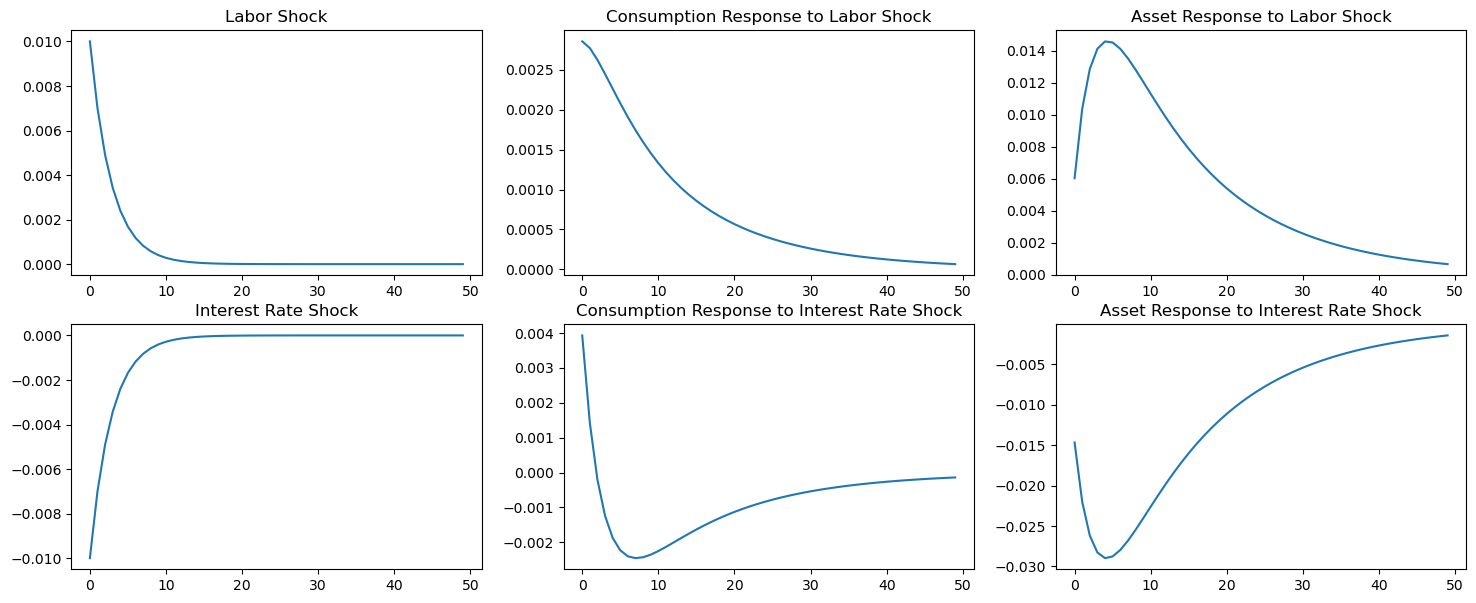

In [68]:
fig, ax = plt.subplots(2,3, figsize=(18, 7))
ax[0, 0].plot(dN[:50])
ax[0, 0].set_title("Labor Shock")
ax[0, 1].plot(IRF_CN[:50])
ax[0, 1].set_title("Consumption Response to Labor Shock")
ax[0, 2].plot(IRF_AN[:50])
ax[0, 2].set_title("Asset Response to Labor Shock")
ax[1, 0].plot(dr[:50])
ax[1, 0].set_title("Interest Rate Shock")
ax[1, 1].plot(IRF_Cr[:50])
ax[1, 1].set_title("Consumption Response to Interest Rate Shock")
ax[1, 2].plot(IRF_Ar[:50])
ax[1, 2].set_title("Asset Response to Interest Rate Shock")
plt.show()

# Step 2: General Equilibrium using `IndShockConsumerType` and SSJ

## 1. Compute General Equilibrium Steady State
Before, we took the discount rate (`DiscFac`) exogeneous. To make sure household savings are equal to aggregate Bond holdings, we have to solve for the general equilibrium discount rate. This also changes the MPC, hence, if you want to adapt MPC change parameter `B_ss` above or target MPC directly.

In [9]:
### Target only Steady State Asset
def ss_func(beta):
    Agent_func = IndShockConsumerType(**Dict, verbose = False)
    Agent_func.DiscFac = beta
    A_ss = Agent_func.compute_steady_state()[0]
    return A_ss
    

def ss_dif(beta):    
    return ss_func(beta) - Asset_target 

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.75,.99)

In [10]:
# Create a new agent
Dict['DiscFac'] = DiscFac
Agent_GE = IndShockConsumerType(**Dict, verbose = False)

In [11]:
A_ss = Agent_GE.compute_steady_state()[0]
MPC = Agent_GE.calc_jacobian('labor',T)[0][0][0]
print('Our general equilibrium agent has a discount rate of: ' +str(Agent_GE.DiscFac) +'. Where the steady state MPC is ' + str(MPC))

Our general equilibrium agent has a discount rate of: 0.9043068641465457. Where the steady state MPC is 0.2679511224012998


## 2. Compute Jacobians with new Steady State

In [12]:
start = time.time()

CJACR_GE, AJACR_GE = Agent_GE.calc_jacobian('Rfree',T)
CJACN_GE, AJACN_GE = Agent_GE.calc_jacobian('labor', T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 28.423866271972656


## 3. Set Up General Equilibrium Parts
We use here [HANK with Fiscal Policy](https://github.com/shade-econ/nber-workshop-2022/blob/main/Tutorials/Tutorial%201%20Fiscal%20Policy.ipynb). A very simple model with a government. Adapting it to firms and monetary policy should be straight forward.

### 3.1 Adding blocks

In [13]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B  # total tax burden
    Z = Y - T  # after tax income
    deficit = G - T
    
    return T, Z, deficit

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt

### 3.2 Include Steady State and Jacobian Dictionaries into SSJ

In [45]:
HARK_SteadyState_Dict = SteadyStateDict({"C": C_ss, "r": r_ss, "Y": Y_ss, "B": B_ss, "G":G_ss, "A": A_ss})
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'Z' : CJACN_GE, 'r': CJACR_GE} ,'A' : {'Z' : AJACN_GE, 'r': AJACR_GE} } ) 

### 3.3 Create Jacobians for GE blocks

In [47]:
J_fiscal = fiscal.jacobian(HARK_SteadyState_Dict, inputs=['B', 'G', 'Y'])

In [48]:
J_fiscal

<JacobianDict outputs=['T', 'Z', 'deficit'], inputs=['B', 'G', 'Y']>

## 4. Generate General Equilibrium Jacobians

### 4.1 Combining partial equilibrium Jacobians by Hand
As the HARK Jacobian Dictionary is written in the class of a `JacobianDict` from SSJ, you can combine jacobians by hand.

In [49]:
print(HARK_Jacobian_Dict['C']['Z'] @ J_fiscal['T']['G'])

[[ 2.67951122e-01  2.03982653e-01  1.30127708e-01 ...  7.94575368e-16
   7.94560058e-16  7.94545196e-16]
 [ 1.67200004e-01  2.67951122e-01  1.59530851e-01 ...  7.42329907e-16
   7.42314960e-16  7.42300455e-16]
 [ 1.15451565e-01  1.67200004e-01  2.38156928e-01 ...  6.92827920e-16
   6.92813275e-16  6.92799054e-16]
 ...
 [ 1.11022302e-09 -1.55653274e-11 -1.90647787e-11 ...  2.13450494e-01
   1.24591700e-01  8.13420655e-02]
 [ 1.11022302e-09 -1.55653274e-11 -1.90647787e-11 ...  1.29727130e-01
   2.13450494e-01  1.24591700e-01]
 [ 1.11022302e-09 -1.55653274e-11 -1.90647787e-11 ...  8.94233978e-02
   1.29727130e-01  2.13450494e-01]]


### 4.2 Using SSJ for impulse response functions
The faster way to get IRFs is to create a model replacing the `HetBlock` with the HARK Jacobian Dictionary and use the HARK Steady State Dictionary when needed. All other functions remain untouched. 

In [50]:
HARK_HANK = create_model([HARK_Jacobian_Dict, fiscal, mkt_clearing], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['G']

G_std = .01
G_persistence = .8
dG =  G_std * G_persistence**np.arange(T)
shocks_G = {"G": dG}

In [51]:
irfs_G = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_G)

In [19]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

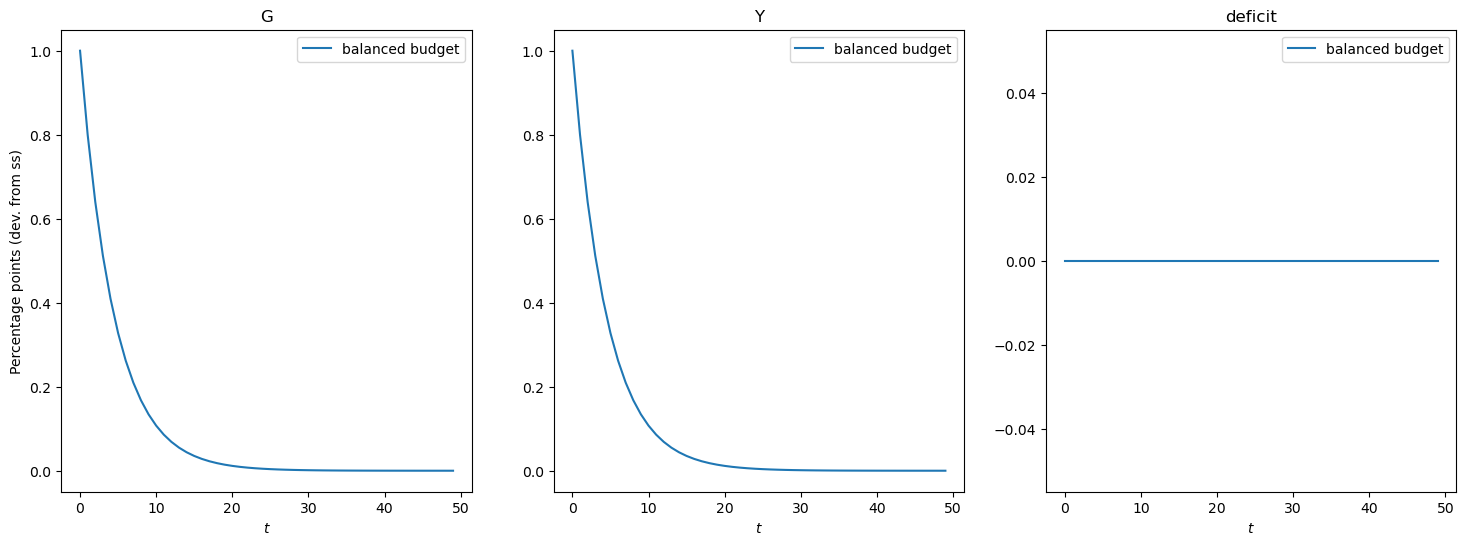

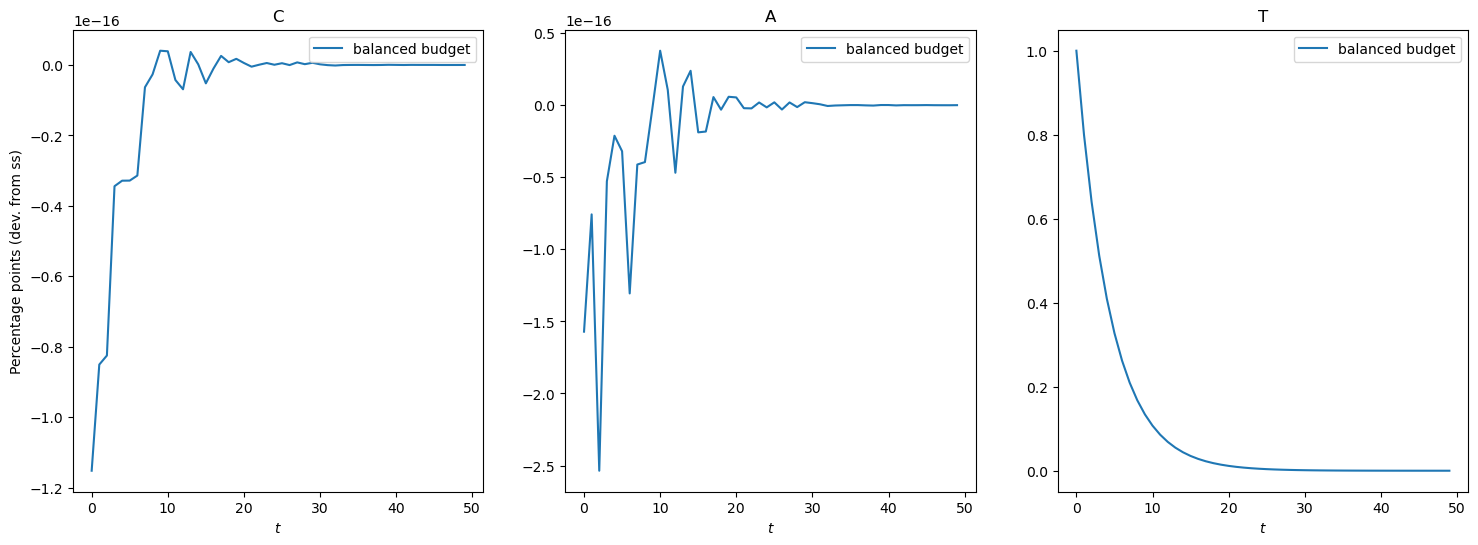

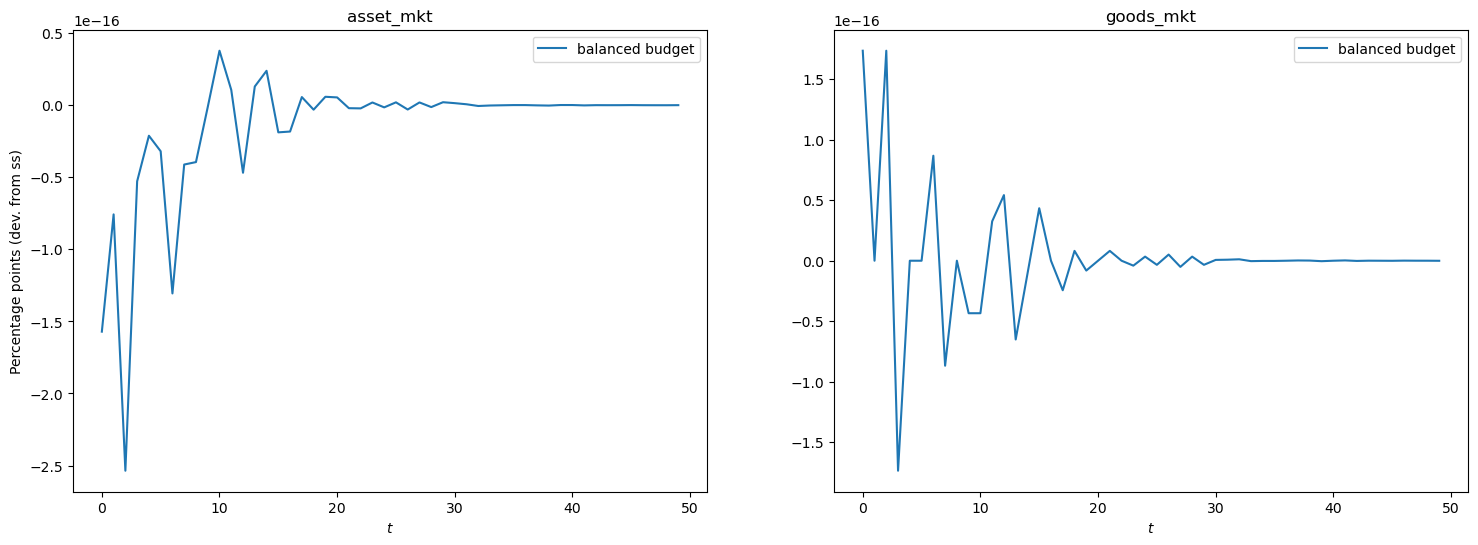

In [53]:
show_irfs([irfs_G], ['G', 'Y', 'deficit'], labels=["balanced budget"])
show_irfs([irfs_G], ['C', 'A', 'T'], labels=["balanced budget"])
show_irfs([irfs_G], ['asset_mkt', 'goods_mkt'], labels=["balanced budget"])

### Analysing an Interest rate shock
You can simply change the shock you want to analyze.

In [54]:
# Interest rate shock
dr = -0.01 * 0.7 ** np.arange(T)
shocks_r = {'r': dr}    

In [55]:
irfs_r = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_r)

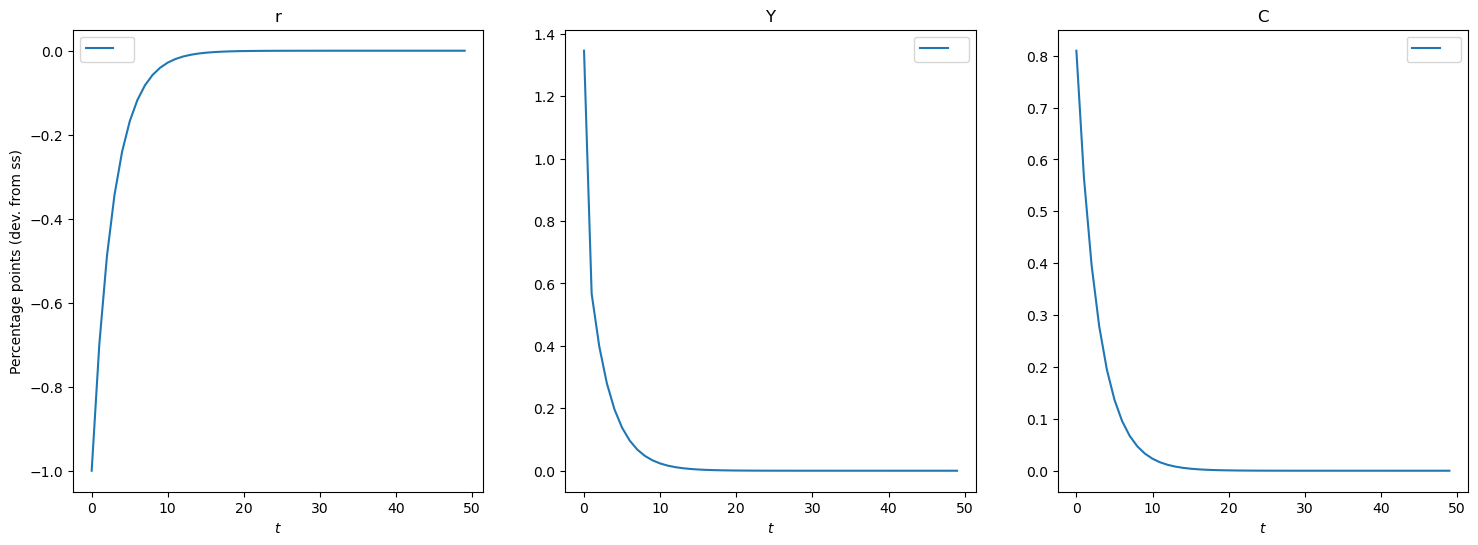

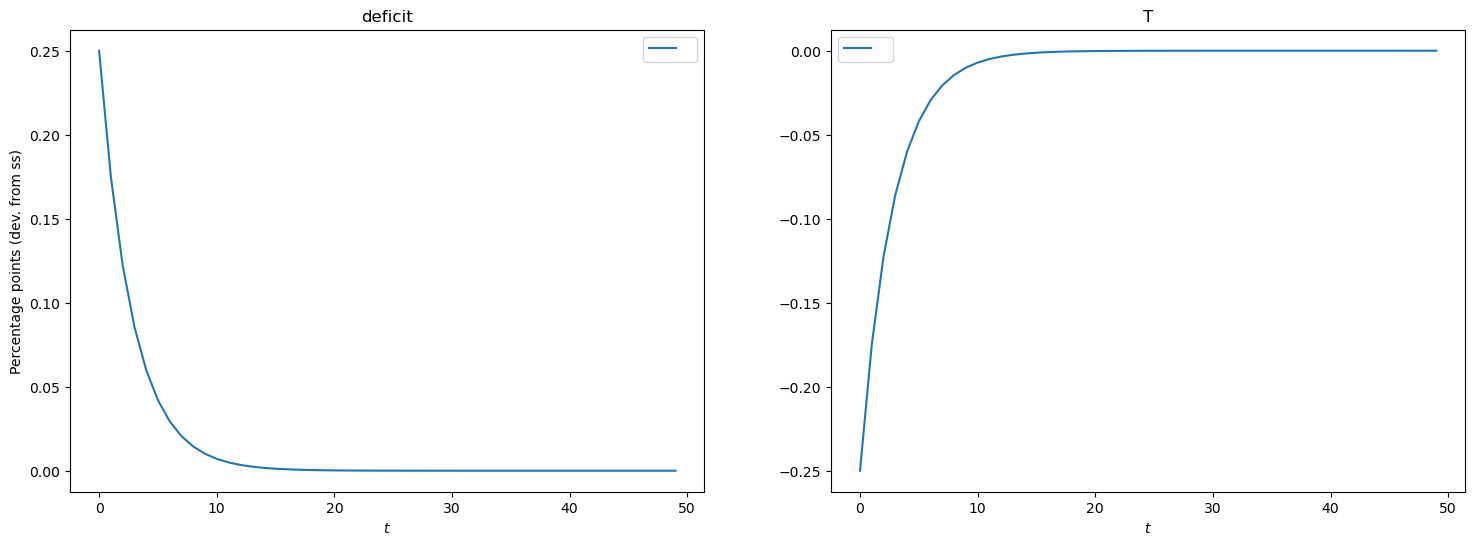

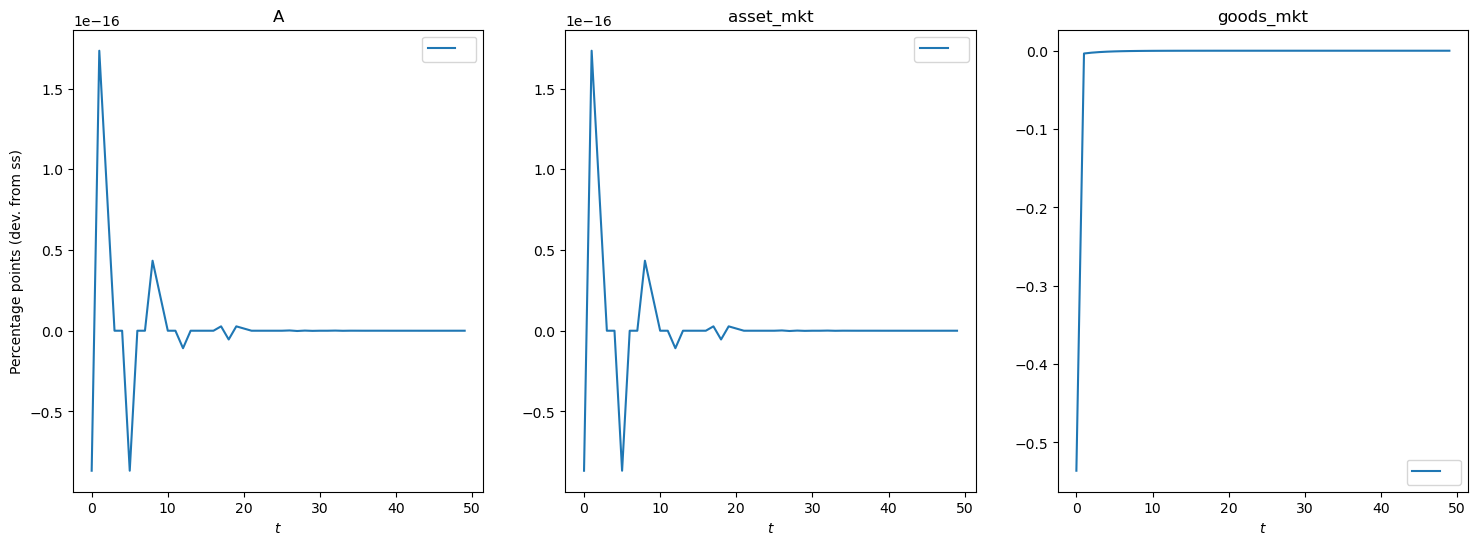

In [56]:
show_irfs([irfs_r], ['r', 'Y', 'C'])
show_irfs([irfs_r], ['deficit', 'T'])
show_irfs([irfs_r], ['A', 'asset_mkt', 'goods_mkt'])